In [65]:
import os
import ast
import json
import copy
from glob import glob
from collections import Counter
import sys
sys.path.insert(0, '../')

import pandas as pd
import numpy as np
from sklearn.feature_extraction.text import TfidfVectorizer

import matplotlib.pyplot as plt
import seaborn as sns
plt.style.use('ggplot')

import networkx as nx
from modules.load_data import load

In [380]:
import matplotlib.font_manager as fm
path = r'C:\Users\iloveslowfood\Desktop\iloveslowfood\etc\fonts\AppleSDGothicNeo\AppleSDGothicNeoSB.ttf'
fontprop = fm.FontProperties(fname=path, size=14)
# plt.rc('font', family=font_name)

# plt.title('한글 제목', fontproperties=fontprop)
# plt.show()

In [391]:
path = r'C:\Users\iloveslowfood\Desktop\iloveslowfood\etc\fonts\AppleSDGothicNeo\AppleSDGothicNeoSB.ttf'
font_name = fm.FontProperties(fname=path, size=50).get_name()
print(font_name)
plt.rc('font', family=font_name)

AppleSDGothicNeoSB00


In [ ]:
plt.title()

In [298]:
metadata_core = pd.read_csv('../raw/metadata_vocab7000.csv')
# metadata = load('metadata')
metadata_core.columns, metadata_core.shape

(Index(['magazine_id', 'user_id', 'title', 'keyword_list', 'display_url',
        'sub_title', 'reg_ts', 'article_id', 'post_id'],
       dtype='object'),
 (573039, 9))

In [299]:
# 문자열 형태로 저장된 리스트를 리스트로 인식되도록 복구
def str2list(strlist: str) -> list:
    listed = ast.literal_eval(strlist)
    return listed

metadata_core['keyword_list'] = metadata_core['keyword_list'].apply(lambda x: str2list(x))

In [300]:
# 태그별 빈도 파악
def squeeze(arr: list) -> list:
    '''2차원 리스트를 1차원으로 squeeze'''
    result = []
    for l in arr:
        if len(l) > 0 and isinstance(l, list):
            result.extend(l)
        elif not isinstance(l, list):
            result.append(l)
    return result

kwd_counts = pd.Series(squeeze(metadata_core['keyword_list'].tolist())).value_counts()
vocab7000 = kwd_counts.index.tolist() 

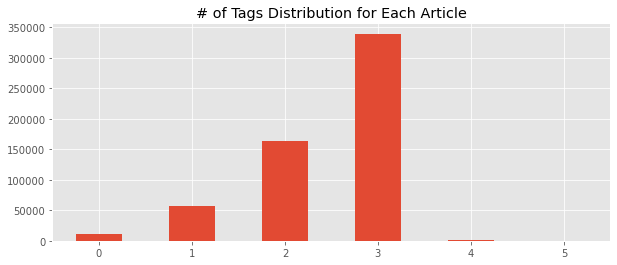

In [21]:

plt.figure(figsize=(10, 4))
metadata_core['keyword_list'].apply(lambda x: len(x)).value_counts(sort=False).plot(kind='bar', rot=0)
plt.title('# of Tags Distribution for Each Article')
plt.show()

글에 달 수 있는 태그는 최대 6개
태그 수가 대부분 2~3개
=> TF-IDF 벡터가 매우 sparse할 것 같다

# TF-IDF Vectorization

In [305]:
metadata_core = pd.read_csv('../raw/metadata_vocab7000.csv')
metadata_core['keyword_list'] = metadata_core['keyword_list'].apply(lambda x: str2list(x))
metadata_core.shape

(573039, 9)

In [306]:
vocab7000 = pd.read_csv('../raw/tag_vocab7000.csv')
vocab7000.head()

,tag,freq
0,여행,33887
1,영화,27058
2,사랑,25177
3,에세이,17629
4,그림일기,15806


In [307]:
user_id = metadata_core['user_id'].head(7000)
kwd_list = metadata_core['keyword_list'].head(7000)

In [308]:
def onehot(sample_row: pd.DataFrame, sample):
    '''
    output.apply(lambda x: onehot(x, sample), axis=1)
    '''
    idx = sample_row.name
    for tag in sample.iloc[idx, :]['keyword_list']:
        sample_row[tag] += 1
    return sample_row

def get_tfidf(data, vocab: list, indices: list=None):
    '''
    tf scale: boolean
    idf scale: logarithmic
    '''
    if isinstance(indices, int):
        indices = [indices]
    vocab_size = len(vocab)
    num_docs = data.shape[0]
    sample = copy.deepcopy(data) if indices is None else data.iloc[indices, :]
    output = pd.DataFrame(np.zeros((sample.shape[0], vocab_size)), columns=vocab)
    
    kwd_list = set(squeeze(sample['keyword_list'].tolist()))
    idf_vec = pd.DataFrame(np.zeros((1, vocab_size)), columns=vocab)
    for tag in kwd_list:
        idf_vec.loc[0, tag] = np.log(num_docs / sum(sample['keyword_list'].apply(lambda x: tag in x)))
    output = output.apply(lambda x: onehot(x, sample), axis=1) * idf_vec.values
    return output

In [309]:
metadata_tfidf = get_tfidf(metadata_core, vocab=vocab, indices=[i for i in range(7000)])
metadata_tfidf.shape

(7000, 7000)

In [335]:
from sklearn.decomposition import PCA
pca = PCA(n_components=3, random_state=3)
pca.fit(output)

PCA(n_components=3, random_state=3)

In [336]:
metadata_pca = pd.DataFrame(pca.transform(output), columns=['comp1', 'comp2', 'comp3'])
metadata_pca['user_id'] = user_id

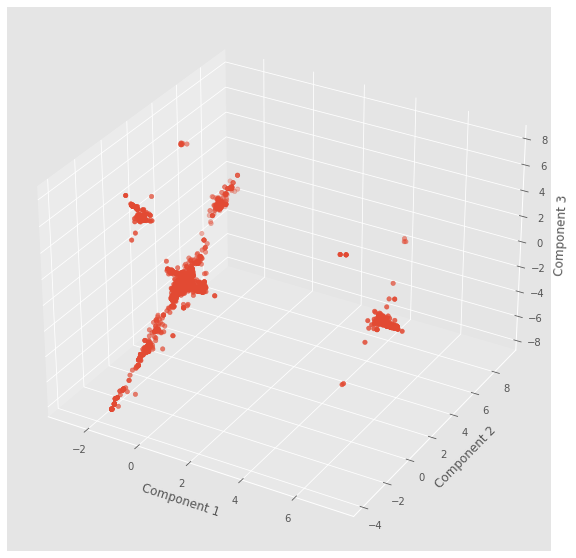

In [337]:
fig = plt.figure(figsize=(10,10))
ax = fig.gca(projection='3d')

x = metadata_pca['comp1']
y = metadata_pca['comp2']
z = metadata_pca['comp3']

ax.scatter(x, y, z)
ax.set_xlabel('Component 1')
ax.set_ylabel('Component 2')
ax.set_zlabel('Component 3')
# plt.tight_layout()
plt.show()

In [345]:
group1 = metadata_pca[(metadata_pca['comp1'] < -2)].index.tolist()
group2 = metadata_pca[(metadata_pca['comp1'] >= -2) & (metadata_pca['comp1'] < 2)].index.tolist()
group3 = metadata_pca[metadata_pca['comp1'] >= 2].index.tolist()

In [346]:
metadata_core.loc[group1, :]['keyword_list']

6         [사랑, 연애, rain]
15      [감성에세이, 사랑, 첫사랑]
88         [슬픔, 자작시, 사랑]
104         [연애, 성격, 사랑]
149      [사랑, 연애, 감성에세이]
              ...       
6845            [결혼, 사랑]
6885        [이별, 사랑, 소설]
6904        [인연, 영화, 사랑]
6933        [사랑, 상처, 유리]
6948            [연애, 사랑]
Name: keyword_list, Length: 228, dtype: object

In [363]:
keyword_freq_g1 = pd.Series(Counter(squeeze(metadata_core.loc[group1, :]['keyword_list'].tolist()))).sort_values(ascending=False)

keyword_freq_g2 = pd.Series(Counter(squeeze(metadata_core.loc[group2, :]['keyword_list'].tolist()))).sort_values(ascending=False)

keyword_freq_g3 = pd.Series(Counter(squeeze(metadata_core.loc[group3, :]['keyword_list'].tolist()))).sort_values(ascending=False)

In [388]:
main_kwd_g1 = keyword_freq_g1.head(15).to_frame().reset_index().rename({'index': '태그', 0: '빈도'}, axis=1)
main_kwd_g2 = keyword_freq_g2.head(15).to_frame().reset_index().rename({'index': '태그', 0: '빈도'}, axis=1)
main_kwd_g3 = keyword_freq_g3.head(15).to_frame().reset_index().rename({'index': '태그', 0: '빈도'}, axis=1)

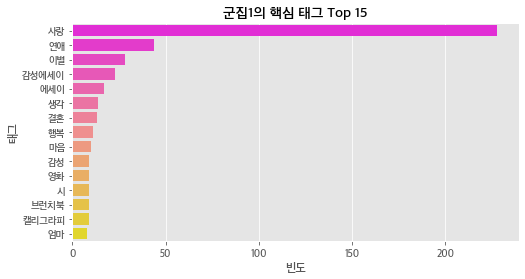

In [416]:
plt.figure(figsize=(8, 4))
sns.barplot(y='태그', x='빈도', data=main_kwd_g1, palette='spring')
plt.title('군집1의 핵심 태그 Top 15')
plt.savefig('./plots/군집1의 핵심 태그 Top 15.png', dpi=300)
plt.show()

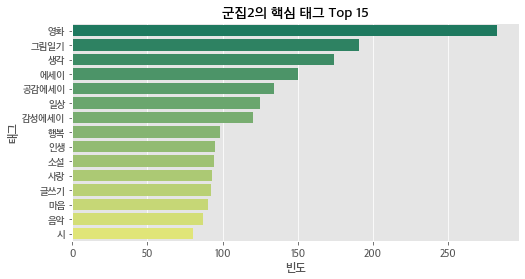

In [417]:
plt.figure(figsize=(8, 4))
sns.barplot(y='태그', x='빈도', data=main_kwd_g2, palette='summer')
plt.title('군집2의 핵심 태그 Top 15')
plt.savefig('./plots/군집2의 핵심 태그 Top 15.png', dpi=300)
plt.show()

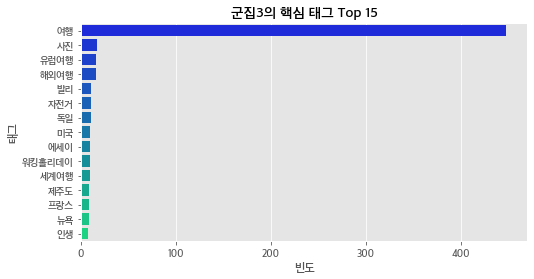

In [418]:
plt.figure(figsize=(8, 4))
sns.barplot(y='태그', x='빈도', data=main_kwd_g3, palette='winter')
plt.title('군집3의 핵심 태그 Top 15')
plt.savefig('./plots/군집3의 핵심 태그 Top 15.png', dpi=300)
plt.show()